In [2]:
from sim_tools import *

In [3]:
from classy import Class

In [4]:
cls = Class()
cls.set({'output':'mTk, vTk', 'z_pk': 1.e6, 'extra_metric_transfer_functions':'yes'})
cls.compute()

In [5]:
import numpy as np
from scipy.integrate import ode
from scipy.interpolate import interp1d
import warnings

class SeparateUniverseGrowthResponse(object) :
	'''
	Computes time evolutions of the separate universe growth response sourced by linear CDM+baryon perturbations
	precomputed in an instance of classy.Class. The growth response can be computed at each wave number tabulated
	in the transfer function interpolation tables accessed using Class.get_transfer.  
	'''
	def __init__(self, cls, quiet = False) :
		'''
		Initialization requires an instance of classy.Class that has 'output':'mTk, vTk' and 'z_pk' set early enough
		for the initial conditions chosen in the SeparateUniverseGrowthResponse.getGrowthResponse method. The instance of
		classy.Class must already be computed.
		'''
		self.cls = cls
		self.quiet = quiet
		if 'gauge' in cls.pars and ('new' in cls.pars['gauge'] or 'New' in cls.pars['gauge']) :
			raise Exception('Error: SeparateUniverseGrowthResponse instance of classy.Class must be computed in the synchronous gause')
		if  not 'vTk' in self.cls.pars['output'] or not ('mTk' in self.cls.pars['output'] or 'dTk' in self.cls.pars['output']) :
			raise Exception('Error: SeparateUniverseGrowthResponse instance of classy.Class \'output\' must contain \'mTk\' and \'vTk\'')
		if self.cls.pars['extra_metric_transfer_functions'] != 'yes' :
			raise Exception('Error: SeparateUniverseGrowthResponse instance of classy.Class must have \'extra_metric_transfer_functions\':\'yes\'')
		if 'z_pk' in self.cls.pars :
			self.z_max = np.max([float(tz) for tz in str( self.cls.pars['z_pk']).split(',')])
			if 'z_max_pk' in self.cls.pars :
				self.z_max = np.max([float(self.cls.pars['z_max_pk']), self.z_max])
		elif 'z_max_pk' in self.cls.pars :
				self.z_max = float(self.cls.pars['z_max_pk'])
		else :
			raise Exception('Error: SeparateUniverseGrowthResponse instance of classy.Class must have \'z_pk\' or \'z_max_pk\'')
		if self.cls.get_transfer() == {} :
			raise Exception('Error: SeparateUniverseGrowthResponse instance of classy.Class must be computed before initialization')		
		#
		# Background
		#
		bg_loga = -np.log(1. + self.cls.get_background()['z'])
		bg_loga[-1] = 0.
		self.fb = self.cls.Omega_b() / (self.cls.Omega_b() + self.cls.Omega0_cdm())
		self.fc = 1. - self.fb
		self.H = interp1d(bg_loga, self.cls.get_background()['H [1/Mpc]'])
		self.zeq = self.cls.z_eq()
		if self.zeq > self.z_max and not self.quiet:
			warnings.warn('SeparateUniverseGrowthResponse.__init__ instance of classy.Class does not compute perturbations early enough' +
						  'for radiation dominated era initial conditions')
		#
		# Separate universe growth response ODE coefficients
		#
		f = self.cls.get_background()['gr.fac. f']
		w = self.cls.get_background()['(.)p_tot'] / self.cls.get_background()['(.)rho_tot']
		Omega_cb = (self.cls.get_background()['(.)rho_cdm'] + self.cls.get_background()['(.)rho_b']) / self.cls.get_background()['(.)rho_crit']
		self.drag = interp1d(bg_loga, 0.5 * (1. - 3. * w + 4. * f))
		self.source1 = interp1d(bg_loga, 1.5 * Omega_cb)
		self.source2 = interp1d(bg_loga, 2. / 3. * f)
		#
		# Thermodynamics
		#
		th_loga = -np.log(1. + self.cls.get_thermodynamics()['z'])
		self.w_b = interp1d(th_loga, self.cls.get_thermodynamics()['w_b'])
		self.c2_b = interp1d(th_loga, self.cls.get_thermodynamics()['c_b^2'])
		
	def getSourceMode(self, loga, k_ind) :
		'''
		Interpolates the CDM+baryon perturbation and its first derivative with respect to log(a) for the mode 
		whose wave number is self.cls.get_transfer(z)['k (h/Mpc)'][k_ind] at log-scale factor log(a) = loga
		'''
		z = np.exp(-loga) - 1.
		try :
			H = self.H(loga)
			c2_b = self.c2_b(loga)
			w_b = self.w_b(loga)
			tf = self.cls.get_transfer(z)
		except ValueError as e :
			raise Exception("Error, redshift %.6e out of interpolation bounds", z)
		delta_cdm = -tf['d_cdm'][k_ind]
		d_delta_cdm_d_loga = 0.5 * tf['h_prime'][k_ind] * (1. + z) / self.H(loga)
		delta_b = -tf['d_b'][k_ind]
		d_delta_b_d_loga =  -3. * (c2_b - w_b) * delta_b  + (1. + w_b) * (tf['t_b'][k_ind] * (1. + z) / H + d_delta_cdm_d_loga)
		return self.fc * delta_cdm + self.fb * delta_b, self.fc * d_delta_cdm_d_loga + self.fb * d_delta_b_d_loga

	def getGrowthResponse(self, k_ind, logai = None, dloga = 1.e-2, nstep = 100, rtol = 1.e-3, atol = 1.e-10) :
		'''
		Numerically integrates the second order ODE for the time evolution of the separate universe
		growth response sourced by a linear CDM+baryon mode with wave length self.cls.get_transfer(z)['k (h/Mpc)'][k_ind].
		Initial conditions are set during radition domination, so loga should not be set too late or the numerical
		solution with have a transcient contribution. 
		'''
		if logai == None :
			logai = -np.log(self.z_max + 1.)
		elif self.zeq > 1. / np.exp(logai) - 1. and not self.quiet :
			 warnings.warn('SeparateUniverseGrowthResponse.getGrowthResponse initial time logai not early enough for radiation dominated era initial conditions')
		if self.z_max < 1. / np.exp(logai) - 1. :
			raise Exception('Error: SeparateUniverseGrowthResponse.getGrowthResponse initial time too early')
		delta_l, d_delta_l_d_loga = self.getSourceMode(logai, k_ind)
		fi = 3. / 2. * self.source2(logai)
		Ri = fi / (1. + fi) / 3. * delta_l
		dRi = 2. * Ri
		def getGrowthResponseDEQs(loga, state) :
			'''
			Second order ODE for separate universe growth response sourced by linear mode delta_l
			'''
			if loga > 0. :
				loga = 0.
			R, dR = state
			delta_l, d_delta_l_d_loga = self.getSourceMode(loga, k_ind)
			deqs = np.zeros(2)
			deqs[0]  = dR
			deqs[1]  = - self.drag(loga) * dR + self.source1(loga) * delta_l + self.source2(loga) * d_delta_l_d_loga
			return deqs
		#
		# Set up integrator and integrate over log(a)
		#
		growth_response_ode = ode(getGrowthResponseDEQs)
		growth_response_ode.set_integrator('lsoda', nsteps = nstep, rtol = rtol, atol = atol)
		growth_response_ode.set_initial_value([Ri, dRi], logai)
		logas = [logai]
		Rs = [Ri]
		stop_time = -2. * dloga
		while growth_response_ode.t < stop_time :
			growth_response_ode.integrate(growth_response_ode.t + dloga)
			if not growth_response_ode.successful() :
				if not self.quiet :
					warnings.warn("SeparateUniverseGrowthResponse.getGrowthResponse failed to integrate at log(a) = %.6e" % (growth_response_ode.t))
				break
			logas.append(growth_response_ode.t)
			Rs.append(growth_response_ode.y[0])
		growth_response_ode.integrate(0.)
		if growth_response_ode.successful() :
			logas.append(growth_response_ode.t)
			Rs.append(growth_response_ode.y[0])	   
		logas = np.array(logas)
		Rs = np.array(Rs)
		delta_ls = np.array([self.getSourceMode(loga, k_ind)[0] for loga in logas])
		return logas, Rs / delta_ls

In [6]:
sugr = SeparateUniverseGrowthResponse(cls, quiet = True)

In [51]:
%%time
#
# Check scale-dependence at a sample of redshifts
#
Rloga, Rs = [], []
for k_ind in range(len(cls.get_transfer(0.)['k (h/Mpc)'])):
    tRloga, tR = sugr.getGrowthResponse(k_ind, -12, dloga = 1.e-1, nstep = 100, rtol = 1.e-3, atol = 1.e-9)
    Rloga.append(tRloga)
    Rs.append(tR)
Rloga = np.array(Rloga)
Rs = np.array(Rs)

CPU times: user 28.3 s, sys: 805 ms, total: 29.1 s
Wall time: 29.8 s


In [16]:
from multiprocessing import Process, Value, Array

In [17]:
from multiprocessing.dummy import Pool as ThreadPool

In [8]:
from concurrent.futures import ThreadPoolExecutor

In [8]:
import concurrent.futures

In [9]:
def single_growth_response(args) :
    #t_sugr = SeparateUniverseGrowthResponse(args[0], quiet = True)
    aa, rr = sugr.getGrowthResponse(args[1], -12, dloga = 1.e-1, nstep = 100, rtol = 1.e-3, atol = 1.e-9)
    print(args[1], rr[-1], len(rr), len(aa))
    return rr[-1]

def parallel_growth_response(t_cls, num_threads = 1) :
    args = [(cls, k_ind) for k_ind in range(len(cls.get_transfer(0.)['k (h/Mpc)']))]  
    with concurrent.futures.ThreadPoolExecutor(max_workers = num_threads) as executor:
        futures = {executor.submit(single_growth_response, t_arg) : t_arg for t_arg in args}
        for future in concurrent.futures.as_completed(futures) :
            continue
            #data = future.result()
        return 1

In [ ]:
%%time
results = parallel_growth_response(cls, 2)

In [1]:
results.result()

NameError: name 'results' is not defined

In [78]:
%%time
responses = [sugr.getGrowthResponse(k_ind, -12, dloga = 1.e-1, nstep = 100, rtol = 1.e-3, atol = 1.e-9) for k_ind in range(len(cls.get_transfer(0.)['k (h/Mpc)']))]

CPU times: user 29.5 s, sys: 927 ms, total: 30.4 s
Wall time: 32.2 s


In [80]:
np.shape(responses)

(114, 2, 121)

In [94]:
np.array(responses)[:, 0, :]

array([[-12. , -11.9, -11.8, ...,  -0.2,  -0.1,   0. ],
       [-12. , -11.9, -11.8, ...,  -0.2,  -0.1,   0. ],
       [-12. , -11.9, -11.8, ...,  -0.2,  -0.1,   0. ],
       ...,
       [-12. , -11.9, -11.8, ...,  -0.2,  -0.1,   0. ],
       [-12. , -11.9, -11.8, ...,  -0.2,  -0.1,   0. ],
       [-12. , -11.9, -11.8, ...,  -0.2,  -0.1,   0. ]])

In [ ]:
# function to be mapped over
def calculateParallel(numbers, threads=2):
    pool = ThreadPool(threads)
    results = pool.map(squareNumber, numbers)
    pool.close()
    pool.join()
    return results

In [ ]:
arr = Array('i', range(10))
p = Process(target=f, args=(num, arr))
    p.start()
    p.join()

    print(num.value)
    print(arr[:])

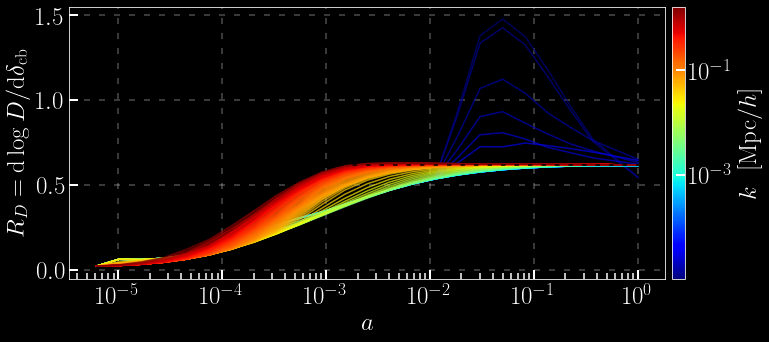

IndexError: index 48 is out of bounds for axis 1 with size 24

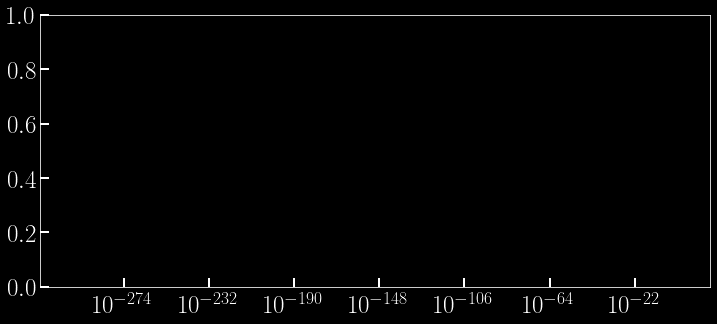

In [15]:
#
# Plots
#
fig, ax = plt.subplots(figsize = (12, 5))
ax.set_xscale('log')
kk = cls.get_transfer(0.)['k (h/Mpc)']
for tk, tloga, tR in zip(kk, Rloga, Rs) :
    logkrat = np.log(tk / kk[0]) / np.log(kk[-1] / kk[0])
    ax.plot(np.exp(tloga), tR,  color = plt.cm.jet(logkrat), alpha = 0.7);
cmap = mpl.cm.jet;
norm = mpl.colors.LogNorm(vmin= kk[0], vmax = kk[-1]);
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, orientation='vertical',
             label='$k\ \ [\mathrm{Mpc}/ h]$', fraction = 0.1, pad = 0.01);
#ax.yaxis.set_major_locator(ticker.MultipleLocator(0.2));
#ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.1));
ax.xaxis.set_major_locator(ticker.LogLocator(base=10, numticks=10, subs=[1.0]));
ax.xaxis.set_minor_locator(ticker.LogLocator(base=10, numticks=10, subs=[1., 2., 3., 4., 5., 6., 7., 8., 9.]));
ax.grid(dashes = (4, 6));
ax.axhline(13. / 21., color = 'black', dashes = (3, 6));
ax.set_xlabel('$a$')
ax.set_ylabel('$R_D = \mathrm{d} \log D / \mathrm{d} \delta_{\mathrm{cb}}$');
plt.show()
#
# Ratio plots
#
fig, ax = plt.subplots(figsize = (12, 5))
ax.set_xscale('log')
for z_ind in [48, 52, 56, 60] :
    ax.plot(cls.get_transfer(0.)['k (h/Mpc)'], Rs[:, z_ind] / Rs[-1, z_ind], label = '$z = %.1f$' % (1. / np.exp(Rloga[-1, z_ind]) - 1.));
ax.legend();
ax.axhline(1., color = 'black', dashes = (3, 6));
#ax.yaxis.set_major_locator(ticker.MultipleLocator(0.004));
#ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.002));
ax.xaxis.set_major_locator(ticker.LogLocator(base=10, numticks=10, subs=[1.0]));
ax.xaxis.set_minor_locator(ticker.LogLocator(base=10, numticks=10, subs=[1., 2., 3., 4., 5., 6., 7., 8., 9.]));
ax.grid(dashes = (4, 6));
ax.set_xlabel('$k\ \ [\mathrm{Mpc}/h]$')
ax.set_ylabel('$R_D(k) / R_D(1.6\ \mathrm{Mpc}^{-1}\, h)$');
plt.show()

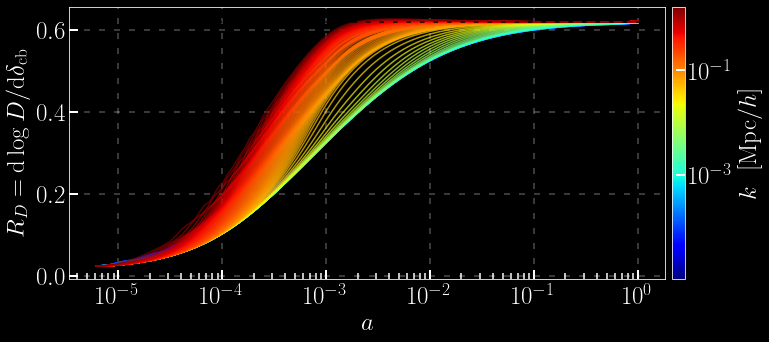

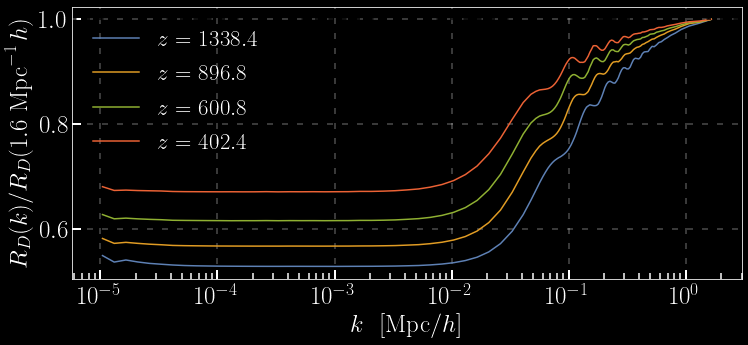

In [10]:
#
# Plots
#
fig, ax = plt.subplots(figsize = (12, 5))
ax.set_xscale('log')
kk = cls.get_transfer(0.)['k (h/Mpc)']
for tk, tloga, tR in zip(kk, Rloga, Rs) :
    logkrat = np.log(tk / kk[0]) / np.log(kk[-1] / kk[0])
    ax.plot(np.exp(tloga), tR,  color = plt.cm.jet(logkrat), alpha = 0.7);
cmap = mpl.cm.jet;
norm = mpl.colors.LogNorm(vmin= kk[0], vmax = kk[-1]);
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, orientation='vertical',
             label='$k\ \ [\mathrm{Mpc}/ h]$', fraction = 0.1, pad = 0.01);
#ax.yaxis.set_major_locator(ticker.MultipleLocator(0.2));
#ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.1));
ax.xaxis.set_major_locator(ticker.LogLocator(base=10, numticks=10, subs=[1.0]));
ax.xaxis.set_minor_locator(ticker.LogLocator(base=10, numticks=10, subs=[1., 2., 3., 4., 5., 6., 7., 8., 9.]));
ax.grid(dashes = (4, 6));
ax.axhline(13. / 21., color = 'black', dashes = (3, 6));
ax.set_xlabel('$a$')
ax.set_ylabel('$R_D = \mathrm{d} \log D / \mathrm{d} \delta_{\mathrm{cb}}$');
plt.show()
#
# Ratio plots
#
fig, ax = plt.subplots(figsize = (12, 5))
ax.set_xscale('log')
for z_ind in [48, 52, 56, 60] :
    ax.plot(cls.get_transfer(0.)['k (h/Mpc)'], Rs[:, z_ind] / Rs[-1, z_ind], label = '$z = %.1f$' % (1. / np.exp(Rloga[-1, z_ind]) - 1.));
ax.legend();
ax.axhline(1., color = 'black', dashes = (3, 6));
#ax.yaxis.set_major_locator(ticker.MultipleLocator(0.004));
#ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.002));
ax.xaxis.set_major_locator(ticker.LogLocator(base=10, numticks=10, subs=[1.0]));
ax.xaxis.set_minor_locator(ticker.LogLocator(base=10, numticks=10, subs=[1., 2., 3., 4., 5., 6., 7., 8., 9.]));
ax.grid(dashes = (4, 6));
ax.set_xlabel('$k\ \ [\mathrm{Mpc}/h]$')
ax.set_ylabel('$R_D(k) / R_D(1.6\ \mathrm{Mpc}^{-1}\, h)$');
plt.show()